# Task 1


In [ ]:
!pip install transformers gensim -q

import os
import random
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

# ===== reproducibility =====
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: C:\Users\xiaoy\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
data_dir = "WOS11967"


file_id = '1EtaRyGb9OEI5LXJqR0a2PhPsz_aKmLno'

if not os.path.exists(data_dir):

    !gdown --id {file_id} --output {data_dir}


In [ ]:
data_dir = "WOS11967"

if not os.path.exists(data_dir):
    # GitHub mirror that includes WOS11967 folder with X.txt, YL1.txt, YL2.txt
    !git clone https://github.com/wuchengyuan88/document-classification.git

    data_dir = "document-classification/WOS11967"

print("Using data dir:", data_dir)


with open(os.path.join(data_dir, "X.txt"), "r", encoding="utf-8") as f:
    texts = [line.strip() for line in f]

yl1 = np.loadtxt(os.path.join(data_dir, "YL1.txt"), dtype=int)
yl2 = np.loadtxt(os.path.join(data_dir, "YL2.txt"), dtype=int)

yl2 = 5 * yl1 + yl2

print("Total samples:", len(texts))
print("YL1 shape:", yl1.shape, "YL2 shape:", yl2.shape)
assert len(texts) == len(yl1) == len(yl2)

Using data dir: WOS11967
Total samples: 11967
YL1 shape: (11967,) YL2 shape: (11967,)


In [ ]:
# 70% train, 15% val, 15% test
train_texts, temp_texts, train_yl1, temp_yl1, train_yl2, temp_yl2 = train_test_split(
    texts, yl1, yl2,
    test_size=0.30,
    random_state=RANDOM_SEED,
    stratify=yl1
)

val_texts, test_texts, val_yl1, test_yl1, val_yl2, test_yl2 = train_test_split(
    temp_texts, temp_yl1, temp_yl2,
    test_size=0.50,
    random_state=RANDOM_SEED,
    stratify=temp_yl1
)

print("Train:", len(train_texts), " Val:", len(val_texts), " Test:", len(test_texts))

Train: 8376  Val: 1795  Test: 1796


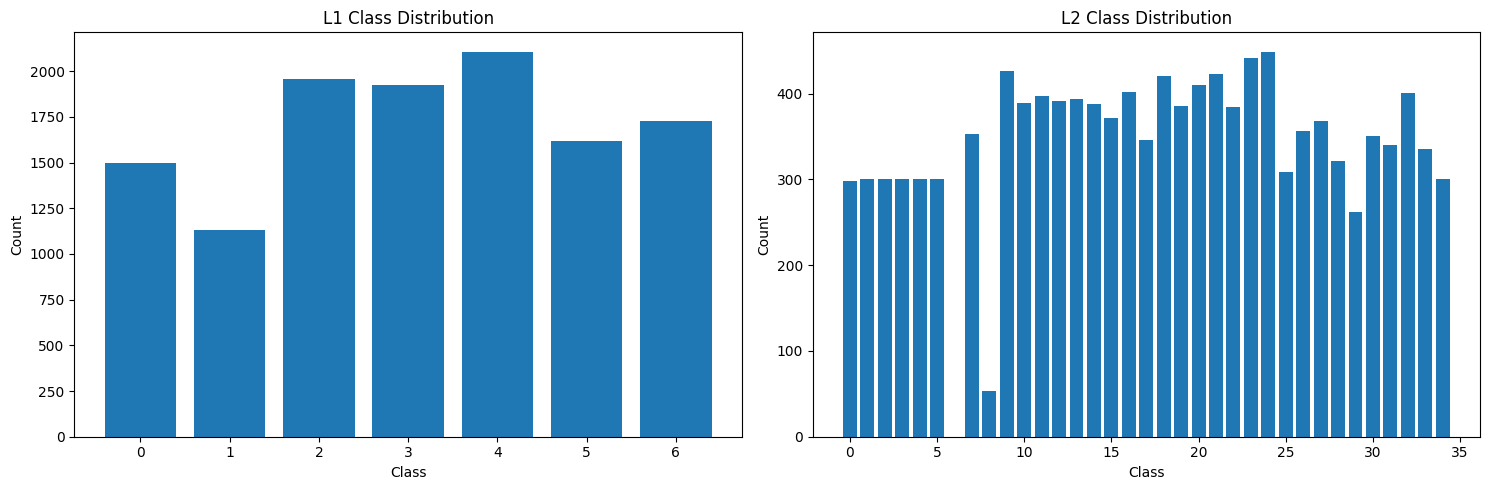

L1 class distribution: Counter({4: 2107, 2: 1959, 3: 1925, 6: 1728, 5: 1617, 0: 1499, 1: 1132})
L2 class distribution: Counter({24: 449, 23: 441, 9: 426, 21: 423, 18: 420, 20: 410, 16: 402, 32: 401, 11: 397, 13: 394, 12: 391, 10: 389, 14: 388, 19: 386, 22: 384, 15: 371, 27: 368, 26: 357, 7: 353, 30: 351, 17: 346, 31: 340, 33: 335, 28: 321, 25: 309, 1: 301, 34: 301, 3: 300, 2: 300, 5: 300, 4: 300, 0: 298, 29: 262, 8: 53})


In [ ]:
# First, let's analyze the class distribution
import matplotlib.pyplot as plt
from collections import Counter

def analyze_class_distribution(y_l1, y_l2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # L1 distribution
    l1_counts = Counter(y_l1)
    ax1.bar(l1_counts.keys(), l1_counts.values())
    ax1.set_title('L1 Class Distribution')
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Count')

    # L2 distribution
    l2_counts = Counter(y_l2)
    ax2.bar(l2_counts.keys(), l2_counts.values())
    ax2.set_title('L2 Class Distribution')
    ax2.set_xlabel('Class')
    ax2.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

    print("L1 class distribution:", l1_counts)
    print("L2 class distribution:", l2_counts)

analyze_class_distribution(yl1, yl2)

In [ ]:
import re
from collections import Counter

def simple_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    return text.split()

counter = Counter()
for txt in train_texts:
    counter.update(simple_tokenize(txt))

MIN_FREQ = 5
itos = ["<PAD>", "<UNK>"]   # index -> token
for word, freq in counter.items():
    if freq >= MIN_FREQ:
        itos.append(word)

stoi = {w: i for i, w in enumerate(itos)}  # token -> index

print("Vocab size:", len(itos))

Vocab size: 17030


In [ ]:
MAX_LEN_LSTM = 200

def encode_text(text, stoi, max_len=MAX_LEN_LSTM):
    tokens = simple_tokenize(text)
    ids = [stoi.get(tok, 1) for tok in tokens]  # UNK = 1
    # padding
    if len(ids) < max_len:
        ids = ids + [0] * (max_len - len(ids))  # PAD = 0
    else:
        ids = ids[:max_len]
    return np.array(ids, dtype=np.int64)

In [ ]:
class WOSLSTMDataset(Dataset):
    def __init__(self, texts, yl1, yl2, stoi, max_len=MAX_LEN_LSTM, label_level="l1"):
        self.texts = texts
        self.yl1 = yl1
        self.yl2 = yl2
        self.stoi = stoi
        self.max_len = max_len
        assert label_level in ["l1", "l2"]
        self.label_level = label_level

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        x_ids = encode_text(self.texts[idx], self.stoi, self.max_len)
        if self.label_level == "l1":
            y = self.yl1[idx]
        else:
            y = self.yl2[idx]
        return torch.tensor(x_ids, dtype=torch.long), torch.tensor(y, dtype=torch.long)

# dataset / dataloader
train_dataset_l1 = WOSLSTMDataset(train_texts, train_yl1, train_yl2, stoi, label_level="l1")
val_dataset_l1   = WOSLSTMDataset(val_texts,   val_yl1,   val_yl2,   stoi, label_level="l1")
test_dataset_l1  = WOSLSTMDataset(test_texts,  test_yl1,  test_yl2,  stoi, label_level="l1")

train_loader_l1 = DataLoader(train_dataset_l1, batch_size=64, shuffle=True)
val_loader_l1   = DataLoader(val_dataset_l1,   batch_size=64)
test_loader_l1  = DataLoader(test_dataset_l1,  batch_size=64)

# batchsize
batch_x, batch_y = next(iter(train_loader_l1))
print("LSTM batch X shape:", batch_x.shape)  # [batch_size, seq_len]
print("LSTM batch y shape:", batch_y.shape)

LSTM batch X shape: torch.Size([64, 200])
LSTM batch y shape: torch.Size([64])


In [ ]:
BERT_MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

MAX_LEN_BERT = 256


In [ ]:
# === Bridge Task1 → Task2: build X_*_lstm & y*_train/val/test ===

X_train_lstm = np.array([encode_text(t, stoi, MAX_LEN_LSTM) for t in train_texts])
X_val_lstm   = np.array([encode_text(t, stoi, MAX_LEN_LSTM) for t in val_texts])
X_test_lstm  = np.array([encode_text(t, stoi, MAX_LEN_LSTM) for t in test_texts])

y1_train = train_yl1
y2_train = train_yl2
y1_val   = val_yl1
y2_val   = val_yl2
y1_test  = test_yl1
y2_test  = test_yl2

print("X_train_lstm shape:", X_train_lstm.shape)
print("X_val_lstm shape:",   X_val_lstm.shape)
print("X_test_lstm shape:",  X_test_lstm.shape)
print("Example y1_train shape:", y1_train.shape, " y2_train shape:", y2_train.shape)

X_train_lstm shape: (8376, 200)
X_val_lstm shape: (1795, 200)
X_test_lstm shape: (1796, 200)
Example y1_train shape: (8376,)  y2_train shape: (8376,)


# Task2


## LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np


In [ ]:
class LSTMDataset(Dataset):
    def __init__(self, X_data, y1_labels, y2_labels):
        self.X_data = torch.LongTensor(X_data)
        self.y1_labels = torch.LongTensor(y1_labels)
        self.y2_labels = torch.LongTensor(y2_labels)

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        return self.X_data[idx], self.y1_labels[idx], self.y2_labels[idx]

In [ ]:
class CustomLSTMCell(nn.Module):
    """
    A single LSTM cell (one layer) implemented from scratch.
    """
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        # Input gate
        self.W_ii = nn.Parameter(torch.randn(hidden_size, input_size) * 0.1)
        self.W_hi = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.b_i  = nn.Parameter(torch.zeros(hidden_size))

        # Forget gate
        self.W_if = nn.Parameter(torch.randn(hidden_size, input_size) * 0.1)
        self.W_hf = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.b_f  = nn.Parameter(torch.zeros(hidden_size))

        # Cell gate
        self.W_ig = nn.Parameter(torch.randn(hidden_size, input_size) * 0.1)
        self.W_hg = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.b_g  = nn.Parameter(torch.zeros(hidden_size))

        # Output gate
        self.W_io = nn.Parameter(torch.randn(hidden_size, input_size) * 0.1)
        self.W_ho = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.b_o  = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x_t, h_prev, c_prev):
        """
        x_t:    (batch, input_size)
        h_prev: (batch, hidden_size)
        c_prev: (batch, hidden_size)
        """
        # input gate
        i_t = torch.sigmoid(
            x_t @ self.W_ii.T + h_prev @ self.W_hi.T + self.b_i
        )
        # forget gate
        f_t = torch.sigmoid(
            x_t @ self.W_if.T + h_prev @ self.W_hf.T + self.b_f
        )
        # cell candidate
        g_t = torch.tanh(
            x_t @ self.W_ig.T + h_prev @ self.W_hg.T + self.b_g
        )
        # output gate
        o_t = torch.sigmoid(
            x_t @ self.W_io.T + h_prev @ self.W_ho.T + self.b_o
        )

        c_t = f_t * c_prev + i_t * g_t
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t


# -----------------------------
# Multi-layer LSTM using CustomLSTMCell
# -----------------------------
class MultiLayerLSTM(nn.Module):
    """
    Fully custom multi-layer LSTM (no nn.LSTM).
    """
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)

        layers = []
        for layer in range(num_layers):
            layer_input_size = input_size if layer == 0 else hidden_size
            layers.append(CustomLSTMCell(layer_input_size, hidden_size))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        """
        x: (batch, seq_len, input_size)
        returns:
            outputs: (batch, seq_len, hidden_size)  # last layer hidden states for each time step
            (h_n, c_n):
                h_n: (num_layers, batch, hidden_size)
                c_n: (num_layers, batch, hidden_size)
        """
        batch_size, seq_len, _ = x.size()

        # init h, c for each layer
        h = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
        c = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]

        outputs = []

        # time loop
        for t in range(seq_len):
            input_t = x[:, t, :]  # (batch, input_size)

            # layer loop
            for layer in range(self.num_layers):
                h[layer], c[layer] = self.layers[layer](input_t, h[layer], c[layer])
                input_t = h[layer]  # output of current layer is input to next layer

                if layer < self.num_layers - 1:
                    input_t = self.dropout(input_t)

            # we collect last layer's h_t as output for this time step
            outputs.append(h[-1])

        outputs = torch.stack(outputs, dim=1)  # (batch, seq_len, hidden_size)
        h_n = torch.stack(h, dim=0)           # (num_layers, batch, hidden_size)
        c_n = torch.stack(c, dim=0)           # (num_layers, batch, hidden_size)

        return outputs, (h_n, c_n)


# -----------------------------
# LSTMModel with attention + multi-task heads
# -----------------------------
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size,
                 output_dim_l1, output_dim_l2,
                 embedding_matrix, num_layers=2,
                 dropout=0.5, use_attention=True):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.use_attention = use_attention

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding.weight = nn.Parameter(torch.from_numpy(embedding_matrix).float())
        self.embedding.weight.requires_grad = True  # fine-tune

        # Custom multi-layer LSTM (no nn.LSTM)
        self.lstm = MultiLayerLSTM(embedding_dim, hidden_size, num_layers, dropout)

        # Attention mechanism
        if use_attention:
            self.attention = nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, 1)
            )

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Batch normalization
        self.bn_l1 = nn.BatchNorm1d(hidden_size)
        self.bn_l2 = nn.BatchNorm1d(hidden_size)

        # Output layers
        self.fc_l1 = nn.Linear(hidden_size, output_dim_l1)
        self.fc_l2 = nn.Linear(hidden_size, output_dim_l2)

    # ---------- forward + attention ----------
    def attention_forward(self, lstm_output):
        # lstm_output: (batch_size, seq_len, hidden_size)
        attn_scores = self.attention(lstm_output)            # (batch, seq, 1)
        attn_weights = F.softmax(attn_scores.squeeze(-1), dim=1)  # (batch, seq)
        context = torch.bmm(attn_weights.unsqueeze(1), lstm_output)  # (batch, 1, hidden)
        return context.squeeze(1), attn_weights              # (batch, hidden), (batch, seq)

    def forward(self, x):
        """
        x: (batch, seq_len)  (token ids)
        """
        embedded = self.embedding(x)  # (batch, seq_len, emb_dim)
        lstm_out, (hidden, cell) = self.lstm(embedded)

        if self.use_attention:
            context, attn_weights = self.attention_forward(lstm_out)
        else:
            # use last layer's final hidden state
            context = hidden[-1]  # (batch, hidden_size)

        context = self.dropout(context)

        out_l1 = self.bn_l1(context)
        out_l1 = self.fc_l1(out_l1)

        out_l2 = self.bn_l2(context)
        out_l2 = self.fc_l2(out_l2)

        return out_l1, out_l2

    # ---------- evaluation helper ----------
    def evaluate_acc(self, y_true, y_pred):
        correct = (y_pred == y_true).sum().item()
        return correct / len(y_true)

    # ---------- fit ----------
    def fit(self, X_train, y1_train, y2_train,
            X_val, y1_val, y2_val,
            epochs=100, lr=0.001, batch_size=64,
            device='cuda', patience=10):

        train_dataset = LSTMDataset(X_train, y1_train, y2_train)
        val_dataset   = LSTMDataset(X_val,   y1_val,  y2_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

        optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5
        )

        criterion_l1 = nn.CrossEntropyLoss()
        criterion_l2 = nn.CrossEntropyLoss()

        self.to(device)

        best_val_loss = float('inf')
        patience_counter = 0

        train_losses = []
        val_losses = []
        val_accuracies_l1 = []
        val_accuracies_l2 = []

        for epoch in range(epochs):
            # ---- train ----
            self.train()
            total_train_loss = 0.0

            train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
            for batch_x, batch_y1, batch_y2 in train_bar:
                batch_x  = batch_x.to(device)
                batch_y1 = batch_y1.to(device)
                batch_y2 = batch_y2.to(device)

                optimizer.zero_grad()
                out_l1, out_l2 = self.forward(batch_x)

                loss_l1 = criterion_l1(out_l1, batch_y1)
                loss_l2 = criterion_l2(out_l2, batch_y2)
                loss = loss_l1 + loss_l2

                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
                optimizer.step()

                total_train_loss += loss.item()
                train_bar.set_postfix({'Loss': f'{loss.item():.4f}'})

            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # ---- validation ----
            self.eval()
            total_val_loss = 0.0
            val_preds_l1, val_true_l1 = [], []
            val_preds_l2, val_true_l2 = [], []

            val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
            with torch.no_grad():
                for batch_x, batch_y1, batch_y2 in val_bar:
                    batch_x  = batch_x.to(device)
                    batch_y1 = batch_y1.to(device)
                    batch_y2 = batch_y2.to(device)

                    out_l1, out_l2 = self.forward(batch_x)
                    loss_l1 = criterion_l1(out_l1, batch_y1)
                    loss_l2 = criterion_l2(out_l2, batch_y2)
                    loss = loss_l1 + loss_l2

                    total_val_loss += loss.item()
                    val_bar.set_postfix({'Val Loss': f'{loss.item():.4f}'})

                    val_preds_l1.extend(torch.argmax(out_l1, dim=1).cpu().numpy())
                    val_true_l1.extend(batch_y1.cpu().numpy())
                    val_preds_l2.extend(torch.argmax(out_l2, dim=1).cpu().numpy())
                    val_true_l2.extend(batch_y2.cpu().numpy())

            avg_val_loss = total_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            val_acc_l1 = self.evaluate_acc(np.array(val_true_l1), np.array(val_preds_l1))
            val_acc_l2 = self.evaluate_acc(np.array(val_true_l2), np.array(val_preds_l2))
            val_accuracies_l1.append(val_acc_l1)
            val_accuracies_l2.append(val_acc_l2)

            scheduler.step(avg_val_loss)

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                torch.save(self.state_dict(), 'best_lstm_model.pth')
            else:
                patience_counter += 1

            print(
                f"Epoch {epoch+1}: "
                f"Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, "
                f"Val Acc L1={val_acc_l1:.4f}, Val Acc L2={val_acc_l2:.4f}, "
                f"LR={optimizer.param_groups[0]['lr']:.6f}"
            )

            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # load best
        self.load_state_dict(torch.load('best_lstm_model.pth', map_location=device))
        return train_losses, val_losses, val_accuracies_l1, val_accuracies_l2

    # ---------- predict ----------
    def predict(self, X_data, device='cuda', batch_size=64):
        self.eval()
        dataset = LSTMDataset(X_data,
                              np.zeros(len(X_data)),
                              np.zeros(len(X_data)))
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        all_preds_l1, all_preds_l2 = [], []

        self.to(device)
        with torch.no_grad():
            for batch_x, _, _ in tqdm(loader, desc="Predicting"):
                batch_x = batch_x.to(device)
                out_l1, out_l2 = self.forward(batch_x)
                all_preds_l1.extend(torch.argmax(out_l1, dim=1).cpu().numpy())
                all_preds_l2.extend(torch.argmax(out_l2, dim=1).cpu().numpy())

        return np.array(all_preds_l1), np.array(all_preds_l2)

## Train Custom LSTM Model



In [ ]:
# Model parameters
output_dim_l1 = len(np.unique(yl1))
output_dim_l2 = np.max(yl2) + 1

print(f"Output dimension for L1: {output_dim_l1}")
print(f"Output dimension for L2: {output_dim_l2}")

# Define vocab_size, embedding_dim, and embedding_matrix
# vocab_size is derived from the length of the vocabulary (stoi dictionary)
vocab_size = len(stoi)
# embedding_dim is a hyperparameter for the embedding layer. Let's set a common value.
embedding_dim = 100 # A common embedding dimension, adjust if specific pre-trained embeddings are used.
# embedding_matrix needs to be initialized. In a full pipeline, this would often be loaded
# from pre-trained word vectors (e.g., Word2Vec, GloVe). Here, we initialize it randomly.
# It should have shape (vocab_size, embedding_dim).
embedding_matrix = np.random.uniform(-0.1, 0.1, (vocab_size, embedding_dim))


# Enhanced hyperparameters
hidden_size = 256
learning_rate = 0.001
epochs = 100
batch_size = 64
num_layers = 2
dropout = 0.5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the improved model
lstm_model = LSTMModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    output_dim_l1=output_dim_l1,
    output_dim_l2=output_dim_l2,
    embedding_matrix=embedding_matrix,
    num_layers=num_layers,
    dropout=dropout,
    use_attention=True
)

# Train the model
print("Starting LSTM model training...")
train_losses, val_losses, val_accuracies_l1, val_accuracies_l2 = lstm_model.fit(
    X_train_lstm, y1_train, y2_train,
    X_val_lstm, y1_val, y2_val,
    epochs=epochs,
    lr=learning_rate,
    batch_size=batch_size,
    device=device,
    patience=10
)
print("LSTM model training complete.")

Output dimension for L1: 7
Output dimension for L2: 35
Using device: cuda
Starting LSTM model training...


Epoch 1/100 [Train]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 1/100 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 1: Train Loss=3.4376, Val Loss=1.9574, Val Acc L1=0.8490, Val Acc L2=0.5749, LR=0.001000


Epoch 2/100 [Train]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 2/100 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 2: Train Loss=1.2227, Val Loss=1.1993, Val Acc L1=0.9031, Val Acc L2=0.7638, LR=0.001000


Epoch 3/100 [Train]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 3/100 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.4736, Val Loss=1.2558, Val Acc L1=0.8774, Val Acc L2=0.7861, LR=0.001000


Epoch 4/100 [Train]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 4/100 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.1889, Val Loss=1.3652, Val Acc L1=0.8914, Val Acc L2=0.7872, LR=0.001000


Epoch 5/100 [Train]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 5/100 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.0897, Val Loss=1.5614, Val Acc L1=0.8891, Val Acc L2=0.7861, LR=0.001000


Epoch 6/100 [Train]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 6/100 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.0477, Val Loss=1.4596, Val Acc L1=0.8797, Val Acc L2=0.7838, LR=0.001000


Epoch 7/100 [Train]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 7/100 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.0395, Val Loss=1.5148, Val Acc L1=0.8975, Val Acc L2=0.7939, LR=0.001000


Epoch 8/100 [Train]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 8/100 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.0251, Val Loss=1.6430, Val Acc L1=0.8897, Val Acc L2=0.7989, LR=0.000500


Epoch 9/100 [Train]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 9/100 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.0141, Val Loss=1.3565, Val Acc L1=0.9014, Val Acc L2=0.8123, LR=0.000500


Epoch 10/100 [Train]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 10/100 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.0062, Val Loss=1.4638, Val Acc L1=0.9120, Val Acc L2=0.8150, LR=0.000500


Epoch 11/100 [Train]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 11/100 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 11: Train Loss=0.0051, Val Loss=1.4745, Val Acc L1=0.9086, Val Acc L2=0.8156, LR=0.000500


Epoch 12/100 [Train]:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 12/100 [Val]:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch 12: Train Loss=0.0030, Val Loss=1.4705, Val Acc L1=0.9081, Val Acc L2=0.8201, LR=0.000500
Early stopping at epoch 12
LSTM model training complete.


C:\Users\xiaoy\AppData\Local\Temp\ipykernel_2528\3464274697.py:305: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load('best_lstm_model.pth', map_

In [ ]:
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import numpy as np

def test_model(model, X_test, y1_test, y2_test, device, batch_size=64):
    model.eval()  # only uses model methods, NOT torch.nn
    test_dataset = LSTMDataset(X_test, y1_test, y2_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    test_preds_l1 = []
    test_true_l1 = []
    test_preds_l2 = []
    test_true_l2 = []

    with torch.no_grad():  # safe, no gradients
        for batch_x, batch_y1, batch_y2 in tqdm(test_loader, desc="Testing"):
            batch_x = batch_x.to(device)

            # Forward pass
            output_l1, output_l2 = model(batch_x)

            # Collect predictions
            test_preds_l1.extend(output_l1.argmax(dim=1).cpu().numpy())
            test_true_l1.extend(batch_y1.numpy())

            test_preds_l2.extend(output_l2.argmax(dim=1).cpu().numpy())
            test_true_l2.extend(batch_y2.numpy())

    # Accuracy
    acc_l1 = model.evaluate_acc(np.array(test_true_l1), np.array(test_preds_l1))
    acc_l2 = model.evaluate_acc(np.array(test_true_l2), np.array(test_preds_l2))

    print(f"Test Accuracy L1: {acc_l1:.4f}")
    print(f"Test Accuracy L2: {acc_l2:.4f}")

    return acc_l1, acc_l2, test_preds_l1, test_true_l1, test_preds_l2, test_true_l2

## Fine-tune BERT Model



In [ ]:
# ---- Dataset ----
class BertDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, y1_labels, y2_labels):
        self.encodings = encodings
        self.y1_labels = torch.LongTensor(y1_labels)
        self.y2_labels = torch.LongTensor(y2_labels)

    def __len__(self):
        return self.encodings['input_ids'].size(0)

    def __getitem__(self, idx):
        return {
            'input_ids':      self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'token_type_ids': self.encodings['token_type_ids'][idx],
            'labels_l1':      self.y1_labels[idx],
            'labels_l2':      self.y2_labels[idx]
        }

print("BertDataset class defined.")

# ---- Hyperparameters ----
bert_learning_rate = 2e-5
bert_epochs        = 3
bert_batch_size    = 16
print(f"BERT fine-tuning hyperparams: LR={bert_learning_rate}, Epochs={bert_epochs}, Batch={bert_batch_size}")

# ---- Encode texts ----
train_encodings = tokenizer(
    train_texts, truncation=True, padding='max_length',
    max_length=MAX_LEN_BERT, return_tensors="pt"
)
val_encodings = tokenizer(
    val_texts, truncation=True, padding='max_length',
    max_length=MAX_LEN_BERT, return_tensors="pt"
)
test_encodings = tokenizer(
    test_texts, truncation=True, padding='max_length',
    max_length=MAX_LEN_BERT, return_tensors="pt"
)

# ---- Datasets & Dataloaders ----
train_dataset = BertDataset(train_encodings, y1_train, y2_train)
val_dataset   = BertDataset(val_encodings,   y1_val,   y2_val)
test_dataset  = BertDataset(test_encodings,  y1_test,  y2_test)

train_loader = DataLoader(train_dataset, batch_size=bert_batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=bert_batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=bert_batch_size, shuffle=False)

print("BERT DataLoaders created.")

# ---- Model ----
from transformers import AutoModel
from torch.optim import AdamW # Import AdamW optimizer

class CustomBertForMultiTask(nn.Module):
    def __init__(self, bert_model_name, num_labels_l1, num_labels_l2):
        super().__init__()
        self.bert = AutoModel.from_pretrained(
            bert_model_name,
            output_attentions=True
        )
        self.dropout = nn.Dropout(0.1)
        self.classifier_l1 = nn.Linear(self.bert.config.hidden_size, num_labels_l1)
        self.classifier_l2 = nn.Linear(self.bert.config.hidden_size, num_labels_l2)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits_l1 = self.classifier_l1(pooled_output)
        logits_l2 = self.classifier_l2(pooled_output)
        return logits_l1, logits_l2, outputs.attentions

bert_model = CustomBertForMultiTask(BERT_MODEL_NAME, output_dim_l1, output_dim_l2)
bert_model.to(device)
print("CustomBertForMultiTask instantiated and moved to:", device)

optimizer   = AdamW(bert_model.parameters(), lr=bert_learning_rate)
criterion_l1 = nn.CrossEntropyLoss()
criterion_l2 = nn.CrossEntropyLoss()

def calculate_accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return (y_true == y_pred).sum().item() / len(y_true)

# ---- Training loop ----
print("Starting BERT fine-tuning...")
for epoch in range(bert_epochs):
    # Train
    bert_model.train()
    total_train_loss = 0.0

    for batch in train_loader:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels_l1      = batch["labels_l1"].to(device)
        labels_l2      = batch["labels_l2"].to(device)

        optimizer.zero_grad()
        logits_l1, logits_l2, _ = bert_model(input_ids, attention_mask, token_type_ids)

        loss_l1 = criterion_l1(logits_l1, labels_l1)
        loss_l2 = criterion_l2(logits_l2, labels_l2)
        loss    = loss_l1 + loss_l2

        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validate
    bert_model.eval()
    total_val_loss = 0.0
    val_true_l1, val_preds_l1 = [], []
    val_true_l2, val_preds_l2 = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            token_type_ids = batch["token_type_ids"].to(device)
            labels_l1      = batch["labels_l1"].to(device)
            labels_l2      = batch["labels_l2"].to(device)

            logits_l1, logits_l2, _ = bert_model(input_ids, attention_mask, token_type_ids)

            loss_l1 = criterion_l1(logits_l1, labels_l1)
            loss_l2 = criterion_l2(logits_l2, labels_l2)
            total_val_loss += (loss_l1 + loss_l2).item()

            val_preds_l1.extend(torch.argmax(logits_l1, dim=1).cpu().numpy())
            val_true_l1.extend(labels_l1.cpu().numpy())
            val_preds_l2.extend(torch.argmax(logits_l2, dim=1).cpu().numpy())
            val_true_l2.extend(labels_l2.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc_l1 = calculate_accuracy(val_true_l1, val_preds_l1)
    val_acc_l2 = calculate_accuracy(val_true_l2, val_preds_l2)

    print(f"Epoch {epoch+1}/{bert_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc L1: {val_acc_l1:.4f} | "
          f"Val Acc L2: {val_acc_l2:.4f}")

print("BERT fine-tuning complete.")

# ---- Evaluate on test set ----
bert_model.eval()
test_true_l1, test_preds_l1 = [], []
test_true_l2, test_preds_l2 = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels_l1      = batch["labels_l1"].to(device)
        labels_l2      = batch["labels_l2"].to(device)

        logits_l1, logits_l2, _ = bert_model(input_ids, attention_mask, token_type_ids)

        test_preds_l1.extend(torch.argmax(logits_l1, dim=1).cpu().numpy())
        test_true_l1.extend(labels_l1.cpu().numpy())
        test_preds_l2.extend(torch.argmax(logits_l2, dim=1).cpu().numpy())
        test_true_l2.extend(labels_l2.cpu().numpy())

test_acc_l1 = calculate_accuracy(test_true_l1, test_preds_l1)
test_acc_l2 = calculate_accuracy(test_true_l2, test_preds_l2)
print(f"Test Acc L1: {test_acc_l1:.4f} | Test Acc L2: {test_acc_l2:.4f}")

BertDataset class defined.
BERT fine-tuning hyperparams: LR=2e-05, Epochs=3, Batch=16
BERT DataLoaders created.
CustomBertForMultiTask instantiated and moved to: cuda
Starting BERT fine-tuning...
Epoch 1/3 | Train Loss: 2.8571 | Val Loss: 1.3298 | Val Acc L1: 0.9231 | Val Acc L2: 0.8156
Epoch 2/3 | Train Loss: 1.0032 | Val Loss: 0.8747 | Val Acc L1: 0.9376 | Val Acc L2: 0.8529
Epoch 3/3 | Train Loss: 0.5883 | Val Loss: 0.8598 | Val Acc L1: 0.9337 | Val Acc L2: 0.8535
BERT fine-tuning complete.
Test Acc L1: 0.9321 | Test Acc L2: 0.8474


# Task 3

In [ ]:

test_acc_l1_lstm, test_acc_l2_lstm, preds_l1, true_l1, preds_l2, true_l2 = test_model(
    lstm_model, X_test_lstm, y1_test, y2_test, device
)
test_acc_l1_bert = test_acc_l1
test_acc_l2_bert = test_acc_l2

Testing:   0%|          | 0/29 [00:00<?, ?it/s]

Test Accuracy L1: 0.8998
Test Accuracy L2: 0.7611


In [ ]:
import pandas as pd

results = pd.DataFrame([
    {
        "Model": "Custom LSTM (multi-task)",
        "Acc L1": test_acc_l1_lstm,
        "Acc L2": test_acc_l2_lstm
    },
    {
        "Model": "BERT (multi-task)",
        "Acc L1": test_acc_l1_bert,
        "Acc L2": test_acc_l2_bert
    }
])

print(results)

results.to_csv("task3_results.csv", index=False)

                      Model    Acc L1    Acc L2
0  Custom LSTM (multi-task)  0.899777  0.761136
1         BERT (multi-task)  0.932071  0.847439


In [ ]:
# ===== Examine attention for some correctly and incorrectly predicted docs =====

bert_model.eval()

# Layer and head to inspect (BERT base: 12 layers, 12 heads)
layer_to_inspect = 11   # The last layer (0-11)
head_to_inspect  = 0    # The 0-th head

num_correct_to_show   = 3   # Number of correct predictions to show
num_incorrect_to_show = 3   # Number of incorrect predictions to show

examples = {
    "correct": [],
    "incorrect": []
}

with torch.no_grad():
    for batch in test_loader:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels_l1      = batch["labels_l1"].to(device)

        # Forward pass, retrieve attention weights
        logits_l1, logits_l2, attentions = bert_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        preds_l1 = logits_l1.argmax(dim=1)  # Use L1 labels to determine correctness

        # 'attentions' is a tuple, length = num_layers
        # attentions[layer_to_inspect]: (batch, num_heads, seq_len, seq_len)
        att_layer = attentions[layer_to_inspect][:, head_to_inspect, :, :]  # (batch, seq_len, seq_len)

        batch_size, seq_len = input_ids.size()

        for i in range(batch_size):
            is_correct = (preds_l1[i] == labels_l1[i]).item()
            key = "correct" if is_correct else "incorrect"

            # If we have enough samples for this category, skip
            if key == "correct" and len(examples["correct"]) >= num_correct_to_show:
                continue
            if key == "incorrect" and len(examples["incorrect"]) >= num_incorrect_to_show:
                continue

            # Attention matrix for the i-th sample (seq_len, seq_len)
            att_matrix = att_layer[i]  # (seq_len, seq_len)

            # Attention from [CLS] to all tokens: 0th row
            cls_to_tokens = att_matrix[0]  # (seq_len,)

            # Mask out PAD positions using the attention mask
            mask_i = attention_mask[i]  # (seq_len,)
            cls_to_tokens = cls_to_tokens.masked_fill(mask_i == 0, float('-inf'))

            # Get token IDs and corresponding text tokens
            token_ids = input_ids[i].cpu().tolist()
            tokens = tokenizer.convert_ids_to_tokens(token_ids)

            # Record information
            examples[key].append({
                "tokens": tokens,
                "cls_to_tokens": cls_to_tokens.cpu(),
                "true_l1": labels_l1[i].item(),
                "pred_l1": preds_l1[i].item()
            })

        # If enough correct and incorrect examples are collected, break the loop early
        if len(examples["correct"]) >= num_correct_to_show and len(examples["incorrect"]) >= num_incorrect_to_show:
            break

print("Collected examples: ",
      "correct =", len(examples["correct"]),
      ", incorrect =", len(examples["incorrect"]))

Collected examples:  correct = 3 , incorrect = 3


In [ ]:
# Print the top_k tokens most attended to by [CLS] for each sample
top_k = 10

for kind in ["correct", "incorrect"]:
    print("\n==============================")
    print(f"=== {kind.upper()} EXAMPLES ===")
    print("==============================\n")

    for idx, ex in enumerate(examples[kind]):
        tokens = ex["tokens"]
        scores = ex["cls_to_tokens"]          # tensor of shape (seq_len,)
        true_l1 = ex["true_l1"]
        pred_l1 = ex["pred_l1"]

        # Select indices of top_k values (note: padding has been masked to -inf)
        top_scores, top_indices = torch.topk(scores, k=min(top_k, len(scores)))

        print(f"Example {idx+1} | true L1 = {true_l1} | pred L1 = {pred_l1}")
        print("Top tokens attended by [CLS] (layer", layer_to_inspect, ", head", head_to_inspect, "):")

        for s, j in zip(top_scores.tolist(), top_indices.tolist()):
            tok = tokens[j]
            print(f"  token_idx={j:3d}  token={tok:15s}  attn={s:.4f}")

        # Optionally print the decoded original text for readability:
        decoded = tokenizer.decode(
            [tid for tid in tokenizer.convert_tokens_to_ids(tokens)
             if tid not in [tokenizer.pad_token_id]]
        )
        print("\nDecoded text (truncated):")
        print(decoded[:300], "...\n")


=== CORRECT EXAMPLES ===

Example 1 | true L1 = 4 | pred L1 = 4
Top tokens attended by [CLS] (layer 11 , head 0 ):
  token_idx= 10  token=pollution        attn=0.1355
  token_idx=166  token=.                attn=0.0616
  token_idx= 58  token=.                attn=0.0600
  token_idx= 76  token=.                attn=0.0585
  token_idx=185  token=.                attn=0.0348
  token_idx=125  token=.                attn=0.0338
  token_idx=  9  token=water            attn=0.0236
  token_idx=158  token=sediment         attn=0.0194
  token_idx= 52  token=nutrient         attn=0.0191
  token_idx=114  token=exchange         attn=0.0163

Decoded text (truncated):
[CLS] environmental conservation and management policy first emphasized on water pollution control in japan. however, this kind of passive conservation policy is gradually being shifted to an active approach such as satoumi, which includes the restoration of biodiversity, biological productivity, ha ...

Example 2 | true L1 = 5 | pred 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

layer_to_inspect = 11
head_to_inspect  = 0

max_tokens_to_show = 30

bert_model.eval()

batch = next(iter(test_loader))
input_ids      = batch["input_ids"].to(device)
attention_mask = batch["attention_mask"].to(device)
token_type_ids = batch["token_type_ids"].to(device)

with torch.no_grad():
    logits_l1, logits_l2, attentions = bert_model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
    )

att_layer = attentions[layer_to_inspect][:, head_to_inspect, :, :]  # (batch, seq, seq)

example_idx = 0

att_matrix = att_layer[example_idx].detach().cpu().numpy()   # (seq_len, seq_len)
input_ids_example = batch["input_ids"][example_idx].cpu().numpy()
attention_mask_example = batch["attention_mask"][example_idx].cpu().numpy()

tokens = tokenizer.convert_ids_to_tokens(input_ids_example)

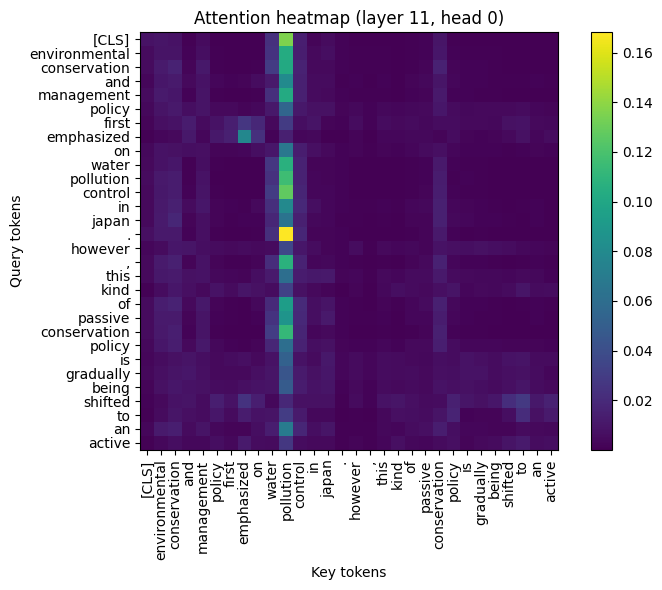

In [ ]:
valid_positions = np.where(attention_mask_example == 1)[0]

valid_positions = valid_positions[:max_tokens_to_show]

att_sub = att_matrix[np.ix_(valid_positions, valid_positions)]
tokens_sub = [tokens[i] for i in valid_positions]

plt.figure(figsize=(8, 6))
plt.imshow(att_sub)
plt.xticks(range(len(tokens_sub)), tokens_sub, rotation=90)
plt.yticks(range(len(tokens_sub)), tokens_sub)
plt.xlabel("Key tokens")
plt.ylabel("Query tokens")
plt.title(f"Attention heatmap (layer {layer_to_inspect}, head {head_to_inspect})")
plt.colorbar()
plt.tight_layout()
plt.show()

# Task
Experiments

In [ ]:
class CustomLSTMCell(nn.Module):
    """
    A single LSTM cell (one layer) implemented from scratch.
    """
    def __init__(self, input_size, hidden_size, forget_bias_init=0.0):
        super().__init__()
        self.hidden_size = hidden_size

        # Input gate
        self.W_ii = nn.Parameter(torch.randn(hidden_size, input_size) * 0.1)
        self.W_hi = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.b_i  = nn.Parameter(torch.zeros(hidden_size))

        # Forget gate
        self.W_if = nn.Parameter(torch.randn(hidden_size, input_size) * 0.1)
        self.W_hf = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        # Initialize forget gate bias to a specific value
        self.b_f  = nn.Parameter(torch.full((hidden_size,), forget_bias_init))

        # Cell gate
        self.W_ig = nn.Parameter(torch.randn(hidden_size, input_size) * 0.1)
        self.W_hg = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.b_g  = nn.Parameter(torch.zeros(hidden_size))

        # Output gate
        self.W_io = nn.Parameter(torch.randn(hidden_size, input_size) * 0.1)
        self.W_ho = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.b_o  = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x_t, h_prev, c_prev):
        """
        x_t:    (batch, input_size)
        h_prev: (batch, hidden_size)
        c_prev: (batch, hidden_size)
        """
        # input gate
        i_t = torch.sigmoid(
            x_t @ self.W_ii.T + h_prev @ self.W_hi.T + self.b_i
        )
        # forget gate
        f_t = torch.sigmoid(
            x_t @ self.W_if.T + h_prev @ self.W_hf.T + self.b_f
        )
        # cell candidate
        g_t = torch.tanh(
            x_t @ self.W_ig.T + h_prev @ self.W_hg.T + self.b_g
        )
        # output gate
        o_t = torch.sigmoid(
            x_t @ self.W_io.T + h_prev @ self.W_ho.T + self.b_o
        )

        c_t = f_t * c_prev + i_t * g_t
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t


# -----------------------------
# Multi-layer LSTM using CustomLSTMCell
# -----------------------------
class MultiLayerLSTM(nn.Module):
    """
    Fully custom multi-layer LSTM (no nn.LSTM).
    """
    def __init__(self, input_size, hidden_size, num_layers, dropout, forget_bias_init=0.0):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)

        layers = []
        for layer in range(num_layers):
            layer_input_size = input_size if layer == 0 else hidden_size
            # Pass forget_bias_init to CustomLSTMCell
            layers.append(CustomLSTMCell(layer_input_size, hidden_size, forget_bias_init=forget_bias_init))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        """
        x: (batch, seq_len, input_size)
        returns:
            outputs: (batch, seq_len, hidden_size)  # last layer hidden states for each time step
            (h_n, c_n):
                h_n: (num_layers, batch, hidden_size)
                c_n: (num_layers, batch, hidden_size)
        """
        batch_size, seq_len, _ = x.size()

        # init h, c for each layer
        h = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]
        c = [torch.zeros(batch_size, self.hidden_size, device=x.device) for _ in range(self.num_layers)]

        outputs = []

        # time loop
        for t in range(seq_len):
            input_t = x[:, t, :]  # (batch, input_size)

            # layer loop
            for layer in range(self.num_layers):
                h[layer], c[layer] = self.layers[layer](input_t, h[layer], c[layer])
                input_t = h[layer]  # output of current layer is input to next layer

                if layer < self.num_layers - 1:
                    input_t = self.dropout(input_t)

            # we collect last layer's h_t as output for this time step
            outputs.append(h[-1])

        outputs = torch.stack(outputs, dim=1)  # (batch, seq_len, hidden_size)
        h_n = torch.stack(h, dim=0)           # (num_layers, batch, hidden_size)
        c_n = torch.stack(c, dim=0)           # (num_layers, batch, hidden_size)

        return outputs, (h_n, c_n)


# -----------------------------
# LSTMModel with attention + multi-task heads
# -----------------------------
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size,
                 output_dim_l1, output_dim_l2,
                 embedding_matrix, num_layers=2,
                 dropout=0.5, use_attention=True,
                 forget_bias_init=0.0, use_batchnorm=True, attention_activation='tanh'):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.use_attention = use_attention
        self.use_batchnorm = use_batchnorm
        self.attention_activation = attention_activation

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding.weight = nn.Parameter(torch.from_numpy(embedding_matrix).float())
        self.embedding.weight.requires_grad = True  # fine-tune

        # Custom multi-layer LSTM (no nn.LSTM)
        # Pass forget_bias_init to MultiLayerLSTM
        self.lstm = MultiLayerLSTM(embedding_dim, hidden_size, num_layers, dropout, forget_bias_init=forget_bias_init)

        # Attention mechanism
        if use_attention:
            # Determine activation function for attention
            if self.attention_activation == 'relu':
                attn_act_fn = nn.ReLU()
            else:
                attn_act_fn = nn.Tanh()

            self.attention = nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                attn_act_fn, # Use the selected activation function
                nn.Linear(hidden_size, 1)
            )

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Batch normalization or Identity
        if self.use_batchnorm:
            self.bn_l1 = nn.BatchNorm1d(hidden_size)
            self.bn_l2 = nn.BatchNorm1d(hidden_size)
        else:
            self.bn_l1 = nn.Identity()
            self.bn_l2 = nn.Identity()

        # Output layers
        self.fc_l1 = nn.Linear(hidden_size, output_dim_l1)
        self.fc_l2 = nn.Linear(hidden_size, output_dim_l2)

    # ---------- forward + attention ----------
    def attention_forward(self, lstm_output):
        # lstm_output: (batch_size, seq_len, hidden_size)
        attn_scores = self.attention(lstm_output)            # (batch, seq, 1)
        attn_weights = F.softmax(attn_scores.squeeze(-1), dim=1)  # (batch, seq)
        context = torch.bmm(attn_weights.unsqueeze(1), lstm_output)  # (batch, 1, hidden)
        return context.squeeze(1), attn_weights              # (batch, hidden), (batch, seq)

    def forward(self, x):
        """
        x: (batch, seq_len)  (token ids)
        """
        embedded = self.embedding(x)  # (batch, seq_len, emb_dim)
        lstm_out, (hidden, cell) = self.lstm(embedded)

        if self.use_attention:
            context, attn_weights = self.attention_forward(lstm_out)
        else:
            # use last layer's final hidden state
            context = hidden[-1]  # (batch, hidden_size)

        context = self.dropout(context)

        out_l1 = self.bn_l1(context)
        out_l1 = self.fc_l1(out_l1)

        out_l2 = self.bn_l2(context)
        out_l2 = self.fc_l2(out_l2)

        return out_l1, out_l2

    # ---------- evaluation helper ----------
    def evaluate_acc(self, y_true, y_pred):
        correct = (y_pred == y_true).sum().item()
        return correct / len(y_true)

    # ---------- fit ----------
    def fit(self, X_train, y1_train, y2_train,
            X_val, y1_val, y2_val,
            epochs=100, lr=0.001, batch_size=64,
            device='cuda', patience=10):

        train_dataset = LSTMDataset(X_train, y1_train, y2_train)
        val_dataset   = LSTMDataset(X_val,   y1_val,  y2_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

        optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5
        )

        criterion_l1 = nn.CrossEntropyLoss()
        criterion_l2 = nn.CrossEntropyLoss()

        self.to(device)

        best_val_loss = float('inf')
        patience_counter = 0

        train_losses = []
        val_losses = []
        val_accuracies_l1 = []
        val_accuracies_l2 = []

        for epoch in range(epochs):
            # ---- train ----
            self.train()
            total_train_loss = 0.0

            train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
            for batch_x, batch_y1, batch_y2 in train_bar:
                batch_x  = batch_x.to(device)
                batch_y1 = batch_y1.to(device)
                batch_y2 = batch_y2.to(device)

                optimizer.zero_grad()
                out_l1, out_l2 = self.forward(batch_x)

                loss_l1 = criterion_l1(out_l1, batch_y1)
                loss_l2 = criterion_l2(out_l2, batch_y2)
                loss = loss_l1 + loss_l2

                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
                optimizer.step()

                total_train_loss += loss.item()
                train_bar.set_postfix({'Loss': f'{loss.item():.4f}'})

            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # ---- validation ----
            self.eval()
            total_val_loss = 0.0
            val_preds_l1, val_true_l1 = [], []
            val_preds_l2, val_true_l2 = [], []

            val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')
            with torch.no_grad():
                for batch_x, batch_y1, batch_y2 in val_bar:
                    batch_x  = batch_x.to(device)
                    batch_y1 = batch_y1.to(device)
                    batch_y2 = batch_y2.to(device)

                    out_l1, out_l2 = self.forward(batch_x)
                    loss_l1 = criterion_l1(out_l1, batch_y1)
                    loss_l2 = criterion_l2(out_l2, batch_y2)
                    loss = loss_l1 + loss_l2

                    total_val_loss += loss.item()
                    val_bar.set_postfix({'Val Loss': f'{loss.item():.4f}'})

                    val_preds_l1.extend(torch.argmax(out_l1, dim=1).cpu().numpy())
                    val_true_l1.extend(batch_y1.cpu().numpy())
                    val_preds_l2.extend(torch.argmax(out_l2, dim=1).cpu().numpy())
                    val_true_l2.extend(batch_y2.cpu().numpy())

            avg_val_loss = total_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            val_acc_l1 = self.evaluate_acc(np.array(val_true_l1), np.array(val_preds_l1))
            val_acc_l2 = self.evaluate_acc(np.array(val_true_l2), np.array(val_preds_l2))
            val_accuracies_l1.append(val_acc_l1)
            val_accuracies_l2.append(val_acc_l2)

            scheduler.step(avg_val_loss)

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                torch.save(self.state_dict(), 'best_lstm_model.pth')
            else:
                patience_counter += 1

            print(
                f"Epoch {epoch+1}: "
                f"Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, "
                f"Val Acc L1={val_acc_l1:.4f}, Val Acc L2={val_acc_l2:.4f}, "
                f"LR={optimizer.param_groups[0]['lr']:.6f}"
            )

            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # load best
        self.load_state_dict(torch.load('best_lstm_model.pth', map_location=device))
        return train_losses, val_losses, val_accuracies_l1, val_accuracies_l2

    # ---------- predict ----------
    def predict(self, X_data, device='cuda', batch_size=64):
        self.eval()
        dataset = LSTMDataset(X_data,
                              np.zeros(len(X_data)),
                              np.zeros(len(X_data)))
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        all_preds_l1, all_preds_l2 = [], []

        self.to(device)
        with torch.no_grad():
            for batch_x, _, _ in tqdm(loader, desc="Predicting"):
                batch_x = batch_x.to(device)
                out_l1, out_l2 = self.forward(batch_x)
                all_preds_l1.extend(torch.argmax(out_l1, dim=1).cpu().numpy())
                all_preds_l2.extend(torch.argmax(out_l2, dim=1).cpu().numpy())

        return np.array(all_preds_l1), np.array(all_preds_l2)

In [ ]:
def train_and_evaluate_lstm_variant(model_name,
                                    dropout=0.5,
                                    use_batchnorm=True,
                                    attention_activation='tanh',
                                    forget_bias_init=0.0):
    print(f"\n--- Training {model_name} ---")
    # Instantiate the model with specific parameters
    variant_model = LSTMModel(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        hidden_size=hidden_size,
        output_dim_l1=output_dim_l1,
        output_dim_l2=output_dim_l2,
        embedding_matrix=embedding_matrix,
        num_layers=num_layers,
        dropout=dropout,
        use_attention=True, # Always use attention for these experiments
        forget_bias_init=forget_bias_init,
        use_batchnorm=use_batchnorm,
        attention_activation=attention_activation
    )

    # Train the model
    _, _, _, _ = variant_model.fit(
        X_train_lstm, y1_train, y2_train,
        X_val_lstm, y1_val, y2_val,
        epochs=epochs, # Using the original epochs (100) and patience (15)
        lr=learning_rate,
        batch_size=batch_size,
        device=device,
        patience=10 # Keep patience same as original LSTM
    )
    print(f"Training for {model_name} complete.")

    # Evaluate the model on the test set
    acc_l1, acc_l2, _, _, _, _ = test_model(
        variant_model, X_test_lstm, y1_test, y2_test, device
    )

    return {"Model": model_name, "Acc L1": acc_l1, "Acc L2": acc_l2}

In [ ]:
new_results = []

# 1. LSTM with Dropout Disabled
new_results.append(train_and_evaluate_lstm_variant(
    "LSTM (Dropout Disabled)",
    dropout=0.0
))

# 2. LSTM with Batch Normalization Disabled
new_results.append(train_and_evaluate_lstm_variant(
    "LSTM (BN Disabled)",
    use_batchnorm=False
))

# 3. LSTM with ReLU Attention
new_results.append(train_and_evaluate_lstm_variant(
    "LSTM (ReLU Attention)",
    attention_activation='relu'
))

# 4. LSTM with Forget Gate Bias +1
new_results.append(train_and_evaluate_lstm_variant(
    "LSTM (Forget Bias +1)",
    forget_bias_init=1.0
))

# Convert new results to DataFrame and concatenate with existing results
new_results_df = pd.DataFrame(new_results)
results = pd.concat([results, new_results_df], ignore_index=True)

print("\nUpdated Results:")
print(results)

# Save updated results to CSV
results.to_csv("task3_results.csv", index=False)


--- Training LSTM (Dropout Disabled) ---


Epoch 1/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 1/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 1: Train Loss=2.3282, Val Loss=1.2538, Val Acc L1=0.8852, Val Acc L2=0.7772, LR=0.001000


Epoch 2/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 2/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.6313, Val Loss=1.1997, Val Acc L1=0.8969, Val Acc L2=0.7944, LR=0.001000


Epoch 3/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 3/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.2378, Val Loss=1.3172, Val Acc L1=0.8975, Val Acc L2=0.8167, LR=0.001000


Epoch 4/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 4/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.1076, Val Loss=1.5254, Val Acc L1=0.9092, Val Acc L2=0.8195, LR=0.001000


Epoch 5/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 5/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.0701, Val Loss=1.5405, Val Acc L1=0.9070, Val Acc L2=0.8145, LR=0.001000


Epoch 6/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 6/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.0572, Val Loss=1.7915, Val Acc L1=0.9042, Val Acc L2=0.8201, LR=0.001000


Epoch 7/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 7/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.0501, Val Loss=1.8373, Val Acc L1=0.8964, Val Acc L2=0.8072, LR=0.001000


Epoch 8/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 8/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.0476, Val Loss=1.8219, Val Acc L1=0.9092, Val Acc L2=0.8295, LR=0.000500


Epoch 9/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 9/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.0173, Val Loss=1.7544, Val Acc L1=0.9125, Val Acc L2=0.8345, LR=0.000500


Epoch 10/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 10/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.0085, Val Loss=1.7317, Val Acc L1=0.9203, Val Acc L2=0.8479, LR=0.000500


Epoch 11/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 11/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 11: Train Loss=0.0024, Val Loss=1.7592, Val Acc L1=0.9175, Val Acc L2=0.8501, LR=0.000500


Epoch 12/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 12/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 12: Train Loss=0.0036, Val Loss=1.7424, Val Acc L1=0.9164, Val Acc L2=0.8407, LR=0.000500
Early stopping at epoch 12
Training for LSTM (Dropout Disabled) complete.


C:\Users\xiaoy\AppData\Local\Temp\ipykernel_2528\2845501467.py:321: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load('best_lstm_model.pth', map_

Testing:   0%|          | 0/29 [00:00<?, ?it/s]

Test Accuracy L1: 0.9031
Test Accuracy L2: 0.7884

--- Training LSTM (BN Disabled) ---


Epoch 1/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 1/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 1: Train Loss=4.6973, Val Loss=4.0803, Val Acc L1=0.4273, Val Acc L2=0.1170, LR=0.001000


Epoch 2/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 2/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 2: Train Loss=4.1004, Val Loss=3.9232, Val Acc L1=0.4875, Val Acc L2=0.1136, LR=0.001000


Epoch 3/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 3/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 3: Train Loss=3.4739, Val Loss=3.2221, Val Acc L1=0.6735, Val Acc L2=0.1448, LR=0.001000


Epoch 4/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 4/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 4: Train Loss=2.9569, Val Loss=3.1574, Val Acc L1=0.6992, Val Acc L2=0.1883, LR=0.001000


Epoch 5/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 5/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 5: Train Loss=2.5250, Val Loss=2.7016, Val Acc L1=0.7928, Val Acc L2=0.2490, LR=0.001000


Epoch 6/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 6/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 6: Train Loss=2.1425, Val Loss=2.5598, Val Acc L1=0.8318, Val Acc L2=0.3348, LR=0.001000


Epoch 7/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 7/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 7: Train Loss=1.7443, Val Loss=2.2727, Val Acc L1=0.8552, Val Acc L2=0.3816, LR=0.001000


Epoch 8/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 8/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 8: Train Loss=1.3770, Val Loss=2.0795, Val Acc L1=0.8607, Val Acc L2=0.4864, LR=0.001000


Epoch 9/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 9/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 9: Train Loss=1.0423, Val Loss=1.9453, Val Acc L1=0.8574, Val Acc L2=0.5922, LR=0.001000


Epoch 10/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 10/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.8022, Val Loss=1.9353, Val Acc L1=0.8630, Val Acc L2=0.6407, LR=0.001000


Epoch 11/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 11/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 11: Train Loss=0.6283, Val Loss=1.8002, Val Acc L1=0.8669, Val Acc L2=0.6869, LR=0.001000


Epoch 12/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 12/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 12: Train Loss=0.4945, Val Loss=1.7592, Val Acc L1=0.8864, Val Acc L2=0.7214, LR=0.001000


Epoch 13/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 13/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 13: Train Loss=0.3743, Val Loss=1.8476, Val Acc L1=0.8691, Val Acc L2=0.7348, LR=0.001000


Epoch 14/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 14/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 14: Train Loss=0.2902, Val Loss=1.7647, Val Acc L1=0.8975, Val Acc L2=0.7549, LR=0.001000


Epoch 15/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 15/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 15: Train Loss=0.2330, Val Loss=1.7609, Val Acc L1=0.8930, Val Acc L2=0.7571, LR=0.001000


Epoch 16/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 16/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 16: Train Loss=0.1825, Val Loss=2.0199, Val Acc L1=0.8836, Val Acc L2=0.7493, LR=0.001000


Epoch 17/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 17/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 17: Train Loss=0.1329, Val Loss=2.1592, Val Acc L1=0.8808, Val Acc L2=0.7599, LR=0.001000


Epoch 18/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 18/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 18: Train Loss=0.1308, Val Loss=2.0508, Val Acc L1=0.8836, Val Acc L2=0.7677, LR=0.000500


Epoch 19/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 19/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 19: Train Loss=0.0606, Val Loss=2.1583, Val Acc L1=0.8886, Val Acc L2=0.7772, LR=0.000500


Epoch 20/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 20/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 20: Train Loss=0.0268, Val Loss=2.2878, Val Acc L1=0.8919, Val Acc L2=0.7772, LR=0.000500


Epoch 21/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 21/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 21: Train Loss=0.0180, Val Loss=2.3725, Val Acc L1=0.8936, Val Acc L2=0.7727, LR=0.000500


Epoch 22/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 22/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 22: Train Loss=0.0148, Val Loss=2.4227, Val Acc L1=0.8919, Val Acc L2=0.7822, LR=0.000500
Early stopping at epoch 22
Training for LSTM (BN Disabled) complete.


Testing:   0%|          | 0/29 [00:00<?, ?it/s]

Test Accuracy L1: 0.8719
Test Accuracy L2: 0.6993

--- Training LSTM (ReLU Attention) ---


Epoch 1/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 1/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 1: Train Loss=3.0869, Val Loss=1.5515, Val Acc L1=0.8891, Val Acc L2=0.6563, LR=0.001000


Epoch 2/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 2/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 2: Train Loss=1.1531, Val Loss=1.0145, Val Acc L1=0.9164, Val Acc L2=0.8017, LR=0.001000


Epoch 3/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 3/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.5977, Val Loss=1.1099, Val Acc L1=0.9103, Val Acc L2=0.8084, LR=0.001000


Epoch 4/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 4/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.3678, Val Loss=1.1885, Val Acc L1=0.9070, Val Acc L2=0.8011, LR=0.001000


Epoch 5/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 5/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.2289, Val Loss=1.4659, Val Acc L1=0.8947, Val Acc L2=0.8106, LR=0.001000


Epoch 6/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 6/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.1461, Val Loss=1.5236, Val Acc L1=0.9136, Val Acc L2=0.8206, LR=0.001000


Epoch 7/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 7/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.1104, Val Loss=1.5244, Val Acc L1=0.9120, Val Acc L2=0.8312, LR=0.001000


Epoch 8/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 8/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.1084, Val Loss=1.4888, Val Acc L1=0.9203, Val Acc L2=0.8262, LR=0.000500


Epoch 9/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 9/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.0317, Val Loss=1.6028, Val Acc L1=0.9164, Val Acc L2=0.8334, LR=0.000500


Epoch 10/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 10/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.0196, Val Loss=1.6120, Val Acc L1=0.9270, Val Acc L2=0.8390, LR=0.000500


Epoch 11/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 11/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 11: Train Loss=0.0076, Val Loss=1.6833, Val Acc L1=0.9231, Val Acc L2=0.8418, LR=0.000500


Epoch 12/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 12/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 12: Train Loss=0.0111, Val Loss=1.8400, Val Acc L1=0.9114, Val Acc L2=0.8284, LR=0.000500
Early stopping at epoch 12
Training for LSTM (ReLU Attention) complete.


Testing:   0%|          | 0/29 [00:00<?, ?it/s]

Test Accuracy L1: 0.9232
Test Accuracy L2: 0.7996

--- Training LSTM (Forget Bias +1) ---


Epoch 1/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 1/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 1: Train Loss=5.4042, Val Loss=4.6310, Val Acc L1=0.4017, Val Acc L2=0.0897, LR=0.001000


Epoch 2/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 2/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 2: Train Loss=4.2406, Val Loss=3.6520, Val Acc L1=0.5638, Val Acc L2=0.1409, LR=0.001000


Epoch 3/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 3/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 3: Train Loss=2.8639, Val Loss=2.5369, Val Acc L1=0.8123, Val Acc L2=0.2897, LR=0.001000


Epoch 4/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 4/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 4: Train Loss=1.7484, Val Loss=1.5540, Val Acc L1=0.8875, Val Acc L2=0.6145, LR=0.001000


Epoch 5/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 5/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 5: Train Loss=1.0871, Val Loss=1.2688, Val Acc L1=0.8969, Val Acc L2=0.7354, LR=0.001000


Epoch 6/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 6/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.6862, Val Loss=1.2763, Val Acc L1=0.8936, Val Acc L2=0.7699, LR=0.001000


Epoch 7/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 7/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.4638, Val Loss=1.2904, Val Acc L1=0.9019, Val Acc L2=0.7967, LR=0.001000


Epoch 8/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 8/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.3087, Val Loss=1.4691, Val Acc L1=0.8869, Val Acc L2=0.7889, LR=0.001000


Epoch 9/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 9/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.2415, Val Loss=1.5409, Val Acc L1=0.8953, Val Acc L2=0.7944, LR=0.001000


Epoch 10/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 10/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.1482, Val Loss=1.8109, Val Acc L1=0.8981, Val Acc L2=0.8028, LR=0.001000


Epoch 11/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 11/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 11: Train Loss=0.1105, Val Loss=1.7864, Val Acc L1=0.8975, Val Acc L2=0.7978, LR=0.000500


Epoch 12/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 12/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 12: Train Loss=0.0487, Val Loss=1.9095, Val Acc L1=0.9053, Val Acc L2=0.8123, LR=0.000500


Epoch 13/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 13/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 13: Train Loss=0.0206, Val Loss=2.2798, Val Acc L1=0.8958, Val Acc L2=0.8006, LR=0.000500


Epoch 14/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 14/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 14: Train Loss=0.0190, Val Loss=2.2738, Val Acc L1=0.9008, Val Acc L2=0.7994, LR=0.000500


Epoch 15/100 [Train]:   0%|          | 0/524 [00:00<?, ?it/s]

Epoch 15/100 [Val]:   0%|          | 0/113 [00:00<?, ?it/s]

Epoch 15: Train Loss=0.0127, Val Loss=2.3915, Val Acc L1=0.9042, Val Acc L2=0.8045, LR=0.000500
Early stopping at epoch 15
Training for LSTM (Forget Bias +1) complete.


Testing:   0%|          | 0/29 [00:00<?, ?it/s]

Test Accuracy L1: 0.8937
Test Accuracy L2: 0.7472

Updated Results:
                      Model    Acc L1    Acc L2
0  Custom LSTM (multi-task)  0.899777  0.761136
1         BERT (multi-task)  0.932071  0.847439
2   LSTM (Dropout Disabled)  0.903118  0.788419
3        LSTM (BN Disabled)  0.871938  0.699332
4     LSTM (ReLU Attention)  0.923163  0.799555
5     LSTM (Forget Bias +1)  0.893653  0.747216


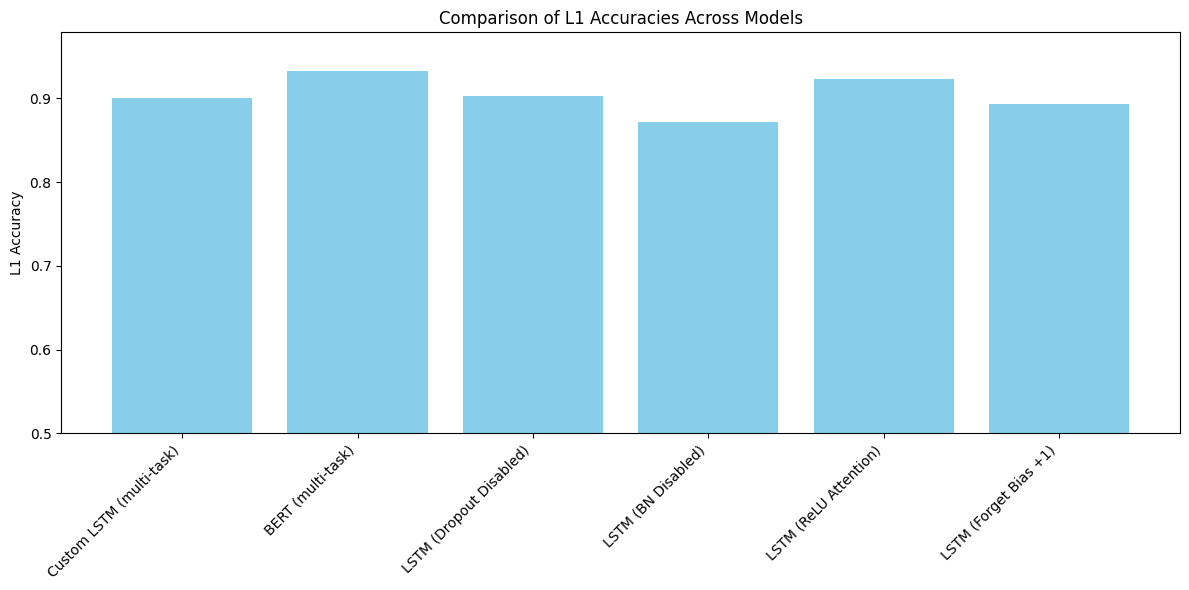

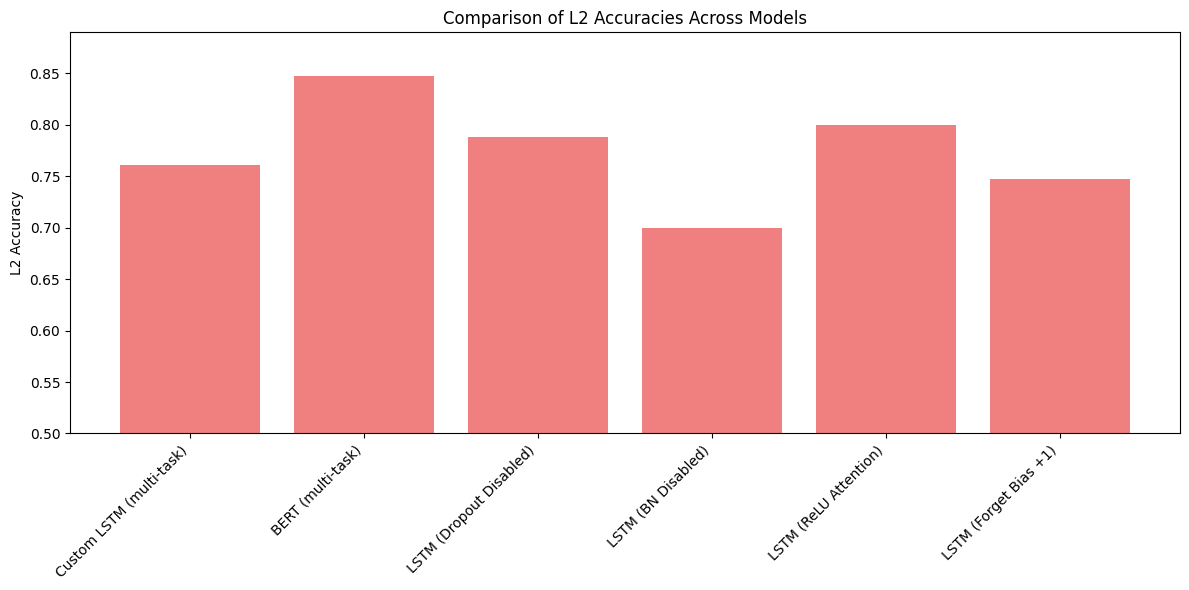

In [ ]:
import matplotlib.pyplot as plt

# Prepare data for plotting
models = results["Model"]
acc_l1 = results["Acc L1"]
acc_l2 = results["Acc L2"]

x_pos = range(len(models))

plt.figure(figsize=(12, 6))
plt.bar(x_pos, acc_l1, color='skyblue') # Using a standard color name
plt.ylabel("L1 Accuracy")
plt.title("Comparison of L1 Accuracies Across Models")
plt.xticks(x_pos, models, rotation=45, ha='right')
plt.ylim(bottom=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(x_pos, acc_l2, color='lightcoral') # Using another standard color name
plt.ylabel("L2 Accuracy")
plt.title("Comparison of L2 Accuracies Across Models")
plt.xticks(x_pos, models, rotation=45, ha='right')
plt.ylim(bottom=0.5)
plt.tight_layout()
plt.show()